# Robot Localisation using a Particle Filter
***
# Table of Contents
1.  [Setup](#Setup)
2.  [Setting up the Environment](#Setting-up-the-Environment)
3.  [Initializing the Robot](#Initializing-the-Robot)
4.  [Conclusion](#Conclusion)
5.  [References](#References)

# Setup

For this assignment I heavily used my work from ex 24 and previous exercises. To better present my work, I removed the
oop aspect of having a robot class and decided to make my robot in the form of a global python dictionary, consequently,
the function classes now access the robot/particles by reference. This allowed me to split my code in several cells
making it easier to explain and mark which part of the assignment where.

For this I will mark each code cell by a quoted text, featuring which exercises where tackled.

Example:

> a(i), a(ii)

```
def sense(rob):
    .
    .
    .
```

Some code cells will have an md cell above it with the sub heading **Code Explanation** and some code cells will have one
beneath them with the sub heading **Comments**. These md cells will have code explanations and comments about the code
and/or results.

I am using python 3.7.

In [1]:
from math import pi, sqrt, cos, sin, atan2, tan, exp
from random import random, gauss
import matplotlib.pyplot as plt
%matplotlib inline

## Comments

Pi and a number of functions from the standard math and random libraries are required for this assignment.

I will be using matplotlib to draw the environment to better visualize and explain what is going on.

# Setting up the Environment

In this step I initialise the landmark locations and and world size.

## Code Explanation
I also code in a drawEnv function which is able to draw the environment boundaries as blue lines and the landmarks as
red circles.

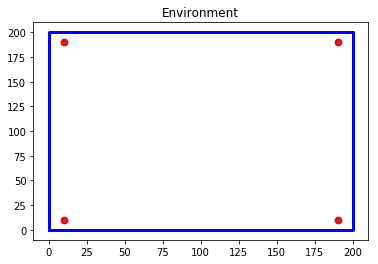

In [2]:
LANDMARKS  = [[10, 10], [190, 190], [10, 190], [190, 10]]
WORLD_SIZE = 200

def drawEnv():
    x_landmark = [10, 190, 10, 190]
    y_landmark = [10, 190, 190, 10]
    # Draw point based on above x, y axis values.
    plt.scatter(x_landmark, y_landmark, s=8, edgecolors="red", linewidths=5)
    x_bounds = [0, 200, 200, 0, 0]
    # List to hold y values.
    y_bounds = [0, 0, 200, 200, 0]
    # Plot the environment bound
    plt.plot(x_bounds, y_bounds, linewidth=3, color='b')
    plt.title("Environment")
drawEnv()
plt.show()

# Initializing the Robot

## Code Explanation

In this step I initialise the robot giving it a random point in the boundary and a random orientation. I also initialise
the robots length, and a number of noise values as instructed by the assignment.

In [3]:
MAX_STEERING_ANGLE = pi / 4 # r
BEARING_NOISE_VAR, STEERING_NOISE_VAR, DISTANCE_NOISE_VAR = (0.1, 0.1, 5)

ROBOT_LENGTH = 10

robot = {
            "front_x": random() * WORLD_SIZE,
            "front_y": random() * WORLD_SIZE,
            "orientation": random() * 2 * pi,
            "steering": 0#-MAX_STEERING_ANGLE + (MAX_STEERING_ANGLE*2)*random()
        }

## Comments

At this stage I decided to initialise the steering angle at 0 so that I can properly test the move function later on.

## Code Explanation

Here I update drawEnv to now include a passed robot when drawing the environment. The robot can be drawn as either a red
or cyan arrow, the direction of the arrow being its orientation.

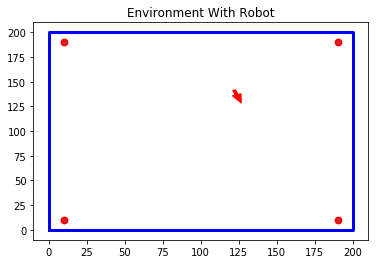

In [4]:
def drawEnvWithBot(rob, red=True):
    drawEnv()
    plt.title("Environment With Robot")
    if red:
        colour = 'r'
    else:
        colour = 'c'
    plt.arrow(rob['front_x'], rob['front_y'], cos(rob['orientation']) * 5, sin(rob['orientation']) * 5, width=2, color=colour)
drawEnvWithBot(robot)
plt.show()

## Comments

The cyan and red colour will help us differentiate between the robot and the particles later on.

# Sense Function

I split this part into two; first the robot senses without having the noise added in, to make sure the function works,
then I add the noise in and check the difference.

> a(i), a(ii)

## Code Explanation

The getAngle function returns the angle between two points.

In [5]:
def getAngle(fromX,fromY,toX,toY):
    deltaX = fromX - toX
    deltaY = fromY - toY
    return atan2(deltaY, deltaX)

## Code Explanation

Sense uses the getAngle function to get the angle between the robot and the four landmarks. This reading ```z``` is
appended to ```Z``` a list.

I also get the euclidean distance between these two points and append the x, y points to ```x2``` and ```y2```, both
lists. This will allow me to plot the sensor readings as lines using matplotlib.

In [17]:
x2 = []
y2 = []

def sense(rob):
    Z = []
    for landmark in LANDMARKS:
        z = getAngle(rob['front_x'], rob['front_y'], landmark[0], landmark[1])
        dist = sqrt(((rob['front_x'] - landmark[0])**2) + ((rob['front_y'] - landmark[1])**2))
        x2.append(rob['front_x'] + dist * -cos(z))
        y2.append(rob['front_y'] + dist * -sin(z))
        Z.append(z)

    return Z

## Code Explanation

Here I add the drawing of the sensor readings by plotting orange lines coming out of the robot, and hopefulyl landing on
the landmarks.

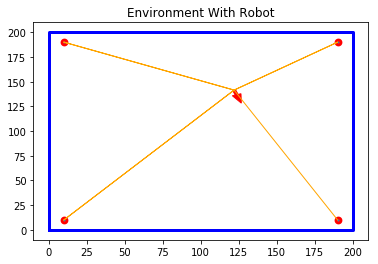

In [6]:
def drawEnvWithSensorReadings(rob):
    line_x = []
    for x in x2:
        line_x.append(rob['front_x'])
        line_x.append(x)

    line_y = []
    for y in y2:
        line_y.append(rob['front_y'])
        line_y.append(y)

    plt.plot(line_x, line_y, linewidth=1, color='orange')
    drawEnvWithBot(rob)

In [ ]:
s = sense(robot)
drawEnvWithSensorReadings(robot)
plt.show()

## Comments

Great, the robot was able to perfectly sense where the landmarks are.


## Code Explanation

Now its time to add noise to the angle and distance readings. This is done by adding a random number from gaussian
distribution with signma = BEARING_NOISE_VAR for the bearing readings and sigma = DISTANCE_NOISE_VAR for the distance
readings.

In [7]:
def sense(rob):
    Z = []
    for landmark in LANDMARKS:
        z = getAngle(rob['front_x'], rob['front_y'], landmark[0], landmark[1])
        z += gauss(0, BEARING_NOISE_VAR)
        dist = sqrt(((rob['front_x'] - landmark[0])**2) + ((rob['front_y'] - landmark[1])**2))
        x2.append(rob['front_x'] + dist * -cos(z) + gauss(0, DISTANCE_NOISE_VAR))
        y2.append(rob['front_y'] + dist * -sin(z) + gauss(0, DISTANCE_NOISE_VAR))
        Z.append(z)

    return Z

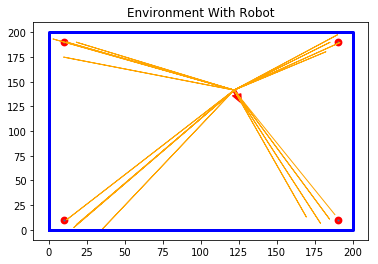

In [8]:
x2 = []
y2 = []

for _ in range(4):
    s = sense(robot)
drawEnvWithSensorReadings(robot)
plt.show()

## Comments

Now that noise is added each sensor reading is different from the other with varying bearing and distance readings. This
confirms that the sense function is working as intended.


# Move Function

In [ ]:
def set_pos(new_x, new_y, new_orientation, new_steering):

    if new_x < 0 or new_x >= WORLD_SIZE:
        new_x = 0 if new_x < 0 else WORLD_SIZE
        new_orientation = - pi
        new_orientation %= (2 * pi)
    if new_y < 0 or new_y >= WORLD_SIZE:
        new_y = 0 if new_y < 0 else WORLD_SIZE
        new_orientation = - pi
        new_orientation %= (2 * pi)
    if new_orientation < 0 or new_orientation >= 2 * pi:
        raise ValueError('Orientation must be in [0..2pi]')
    if new_steering < -MAX_STEERING_ANGLE or new_steering > MAX_STEERING_ANGLE:
        raise ValueError('Steering must be in [-pi/4..pi/4]')
    return float(new_x), float(new_y), float(new_orientation), float(new_steering)

In [9]:
def move(rob, steer_angle, distance):
    if steer_angle < -MAX_STEERING_ANGLE or steer_angle > MAX_STEERING_ANGLE:
        raise ValueError('Robot can only steer in [-pi/4..pi/4]')
    if distance < 0:
        raise ValueError('Robot can only move forward')

    # get steering angle
    steering = steer_angle + gauss(0, STEERING_NOISE_VAR)
    steering = MAX_STEERING_ANGLE if steering > MAX_STEERING_ANGLE else steering
    steering = -MAX_STEERING_ANGLE if steering < MAX_STEERING_ANGLE else steering
    #steering %= MAX_STEERING_ANGLE

    # get distance
    dist = distance + gauss(0.0, DISTANCE_NOISE_VAR)

    # get turn angle
    turn = (dist/ROBOT_LENGTH) * tan(steering)

    if turn > 0.001 or turn < -0.001:
        # Bycicle Model
        r = tan((pi/2) - steering) * ROBOT_LENGTH

        Cx = rob['front_x'] - (r * sin(rob['orientation']))
        Cy = rob['front_y'] + (r * cos(rob['orientation']))

        x = Cx + (r * sin(rob['orientation'] + turn))
        y = Cy - (r * cos(rob['orientation'] + turn))

        orientation = (rob['orientation'] + turn)
        orientation %=( 2 * pi)

    else:
        # Linear Model
        x = rob['front_x'] + (cos(rob['orientation']) * dist)
        y = rob['front_y'] + (sin(rob['orientation']) * dist)
        x %= WORLD_SIZE
        y %= WORLD_SIZE
        orientation = (rob['orientation'] + steering)
        orientation %= (2 * pi)

    rob['front_x'], rob['front_y'], rob['orientation'], rob['steering'] = set_pos(x, y, orientation, steering)
    return rob

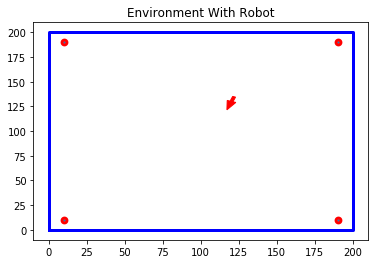

In [10]:
robot = move(robot, 0, 10)

drawEnvWithBot(robot)
plt.show()

# Particle Filter

In [11]:
def Gaussian(mu, sigma, x):
    # calculates the probability of x for 1-dim Gaussian with mean mu and var. sigma
    return exp(- ((mu - x) ** 2) / (sigma ** 2) / 2.0) / sqrt(2.0 * pi * (sigma ** 2))

def measurement_prob(rob, measurement):
    # calculates how likely a measurement should be
    prob = 1.0
    for j, landmark in enumerate(LANDMARKS):
        z = getAngle(rob['front_x'], rob['front_y'], landmark[0], landmark[1])
        # dist = sqrt(((rob['front_x'] - landmark[0])**2) + ((rob['front_y'] - landmark[1])**2))
        prob *= Gaussian(z, BEARING_NOISE_VAR, measurement[j])
    return prob

In [12]:
def evaluate(rob, particles):
    sum = 0.0
    for p in particles: # calculate mean error
        dx = (p['front_x'] - rob['front_x'] + (WORLD_SIZE/2.0)) % (WORLD_SIZE - (WORLD_SIZE/2.0))
        dy = (p['front_y'] - rob['front_y'] + (WORLD_SIZE/2.0)) % (WORLD_SIZE - (WORLD_SIZE/2.0))
        err = sqrt((dx * dx) + (dy * dy))
        sum += err
    return sum / float(len(particles))

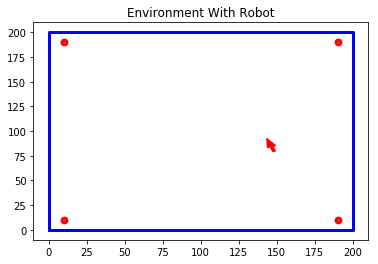

In [13]:
N = 1000
T = 5

robot = {
            "front_x": random() * WORLD_SIZE,
            "front_y": random() * WORLD_SIZE,
            "orientation": random() * 2 * pi,
            "steering": -MAX_STEERING_ANGLE + (MAX_STEERING_ANGLE*2)*random()
        }

drawEnvWithBot(robot)
plt.show()

p = []
for i in range(N):
    r = {
            "front_x": random() * WORLD_SIZE,
            "front_y": random() * WORLD_SIZE,
            "orientation": random() * 2 * pi,
            "steering": -MAX_STEERING_ANGLE + (MAX_STEERING_ANGLE*2)*random()
        }
    p.append(r)

print( 'Mean error at start ', evaluate(robot, p))
for i, _p in enumerate(p):
    print(_p['front_x'], _p['front_y'], _p['orientation'], _p['steering'])
    if i == 5:
        break
for _p in p:
    drawEnvWithBot(_p, False)
plt.show()

In [15]:
for t in range(T):
    robot = move(robot, 0.1, 5.0)

    Z = sense(robot)

    p2 = []
    for _p in p:
        p2.append(move(_p, 0.1, 5.0))
    p = p2

    w = []
    for _p in p:
        w.append(measurement_prob(_p, Z))
    p3 = []

    index = int(random() * N)
    beta = 0.0
    mw = max(w)
    for i in range(N):
        beta += random() * 2.0 * mw
        while beta > w[index]:
            beta -= w[index]
            index = (index + 1) % N
        p3.append(p[index])
    p = p3

    print('Mean error',evaluate(robot, p))

Mean error 95.75738138045965
Mean error 94.5626834956005
Mean error 93.325810201824
Mean error 47.23987226899845
Mean error 50.3556900033399


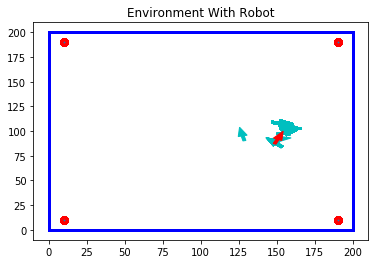

In [16]:
for _p in p:
    drawEnvWithBot(_p, False)

drawEnvWithBot(robot)
plt.show()